* Type (This persons 4 letter MBTI code/type)

* A section of each of the last 50 things they have posted (Each entry separated by "|||" (3 pipe characters))

In [1]:
# Data Analysis
%matplotlib inline
import pandas as pd
import numpy as np
from numpy import asarray
from numpy import savetxt
from numpy import loadtxt
import pickle as pkl
from scipy import sparse

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import wordcloud
from wordcloud import WordCloud, STOPWORDS

# Text Processing
import re
import itertools
import string
import collections
from collections import Counter
from sklearn.preprocessing import LabelEncoder
import nltk
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Machine Learning packages
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import sklearn.cluster as cluster
from sklearn.manifold import TSNE

# Model training and evaluation
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from bayes_opt import BayesianOptimization

#Models
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, multilabel_confusion_matrix, confusion_matrix
from sklearn.metrics import classification_report,  ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold, cross_validate,cross_val_score,GridSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
# Ignore noise warning
import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('mbti_1.csv')

In [3]:
data.head()

type                                              posts
0  INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1  ENTP  'I'm finding the lack of me in these posts ver...
2  INTP  'Good one  _____   https://www.youtube.com/wat...
3  INTJ  'Dear INTP,   I enjoyed our conversation the o...
4  ENTJ  'You're fired.|||That's another silly misconce...

In [4]:
data.tail()

type                                              posts
8670  ISFP  'https://www.youtube.com/watch?v=t8edHB_h908||...
8671  ENFP  'So...if this thread already exists someplace ...
8672  INTP  'So many questions when i do these things.  I ...
8673  INFP  'I am very conflicted right now when it comes ...
8674  INFP  'It has been too long since I have been on per...

In [5]:
data.isna().any()

type     False
posts    False
dtype: bool

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8675 non-null   object
 1   posts   8675 non-null   object
dtypes: object(2)
memory usage: 135.7+ KB


In [7]:
data.shape

(8675, 2)

In [8]:
data.describe(include=['object'])

type                                              posts
count   8675                                               8675
unique    16                                               8675
top     INFP  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
freq    1832                                                  1

* It seems there're 16 unique kind of personality 
* INFP is the most frequently occuring personality

In [9]:
types = np.unique(np.array(data['type']))
types

array(['ENFJ', 'ENFP', 'ENTJ', 'ENTP', 'ESFJ', 'ESFP', 'ESTJ', 'ESTP',
       'INFJ', 'INFP', 'INTJ', 'INTP', 'ISFJ', 'ISFP', 'ISTJ', 'ISTP'],
      dtype=object)

In [10]:
total = data.groupby(['type']).count()
total

posts
type       
ENFJ    190
ENFP    675
ENTJ    231
ENTP    685
ESFJ     42
ESFP     48
ESTJ     39
ESTP     89
INFJ   1470
INFP   1832
INTJ   1091
INTP   1304
ISFJ    166
ISFP    271
ISTJ    205
ISTP    337

In [11]:
# A section of each of the last 50 things they have posted
total = data.groupby(['type']).count()*50
total

posts
type       
ENFJ   9500
ENFP  33750
ENTJ  11550
ENTP  34250
ESFJ   2100
ESFP   2400
ESTJ   1950
ESTP   4450
INFJ  73500
INFP  91600
INTJ  54550
INTP  65200
ISFJ   8300
ISFP  13550
ISTJ  10250
ISTP  16850

## Exploring Data Analysis

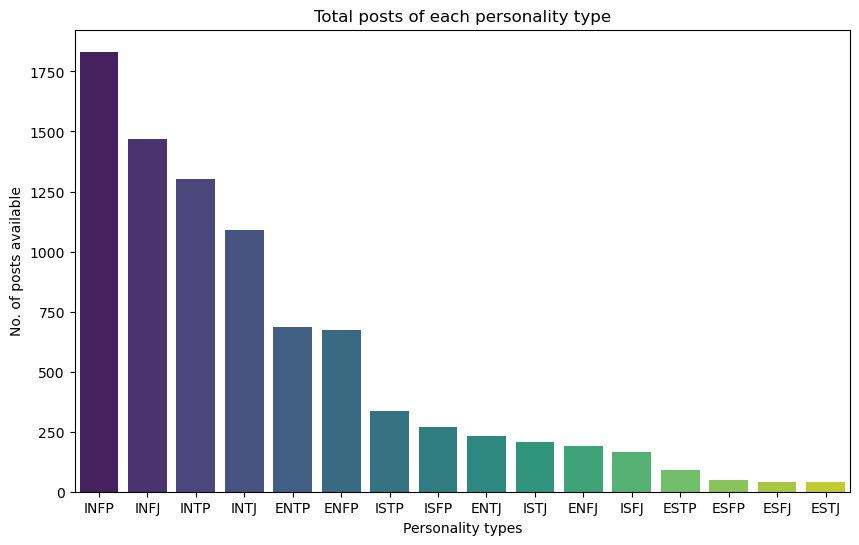

In [12]:
plt.figure(figsize=(10,6))

types_count = data['type'].value_counts()
sns.barplot(x=types_count.index, y=types_count.values, palette='viridis')

plt.xlabel('Personality types', size=10)
plt.ylabel('No. of posts available', size=10)
plt.title('Total posts of each personality type')
plt.show()

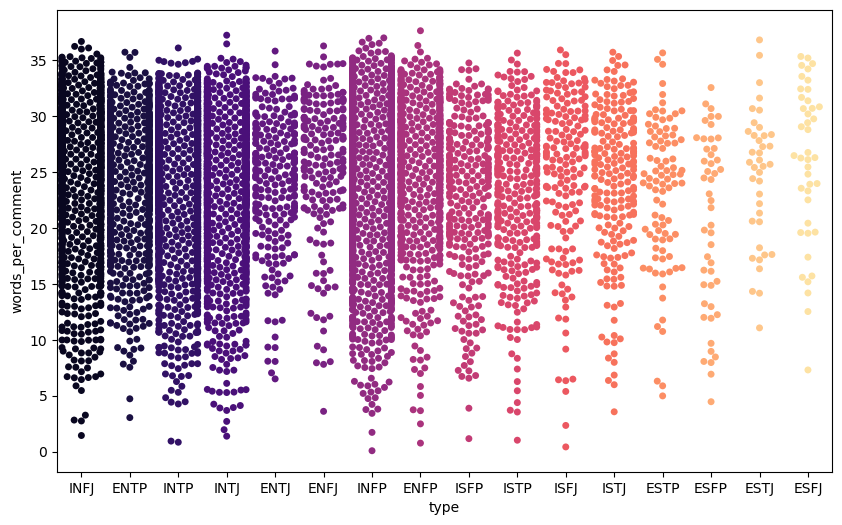

In [13]:
df = data.copy()
# count the number of words in each post of a user, see the data's standard deviation
def std_row(row):
    
    l = []
    for i in row.split('|||'):
        l.append(len(i.split()))
        
    return np.std(l)

# count the number of words per post out of the total 50 posts
df['words_per_comment'] = df['posts'].apply(lambda x: len(x.split())/50)
df['std_of_words_count'] = df['posts'].apply(lambda x: std_row(x))

plt.figure(figsize=(10,6))
sns.swarmplot(data=df, x='type', y='words_per_comment', palette='magma')
plt.show()

Obviously, INFP show the most cluttered

<Figure size 1200x600 with 0 Axes>

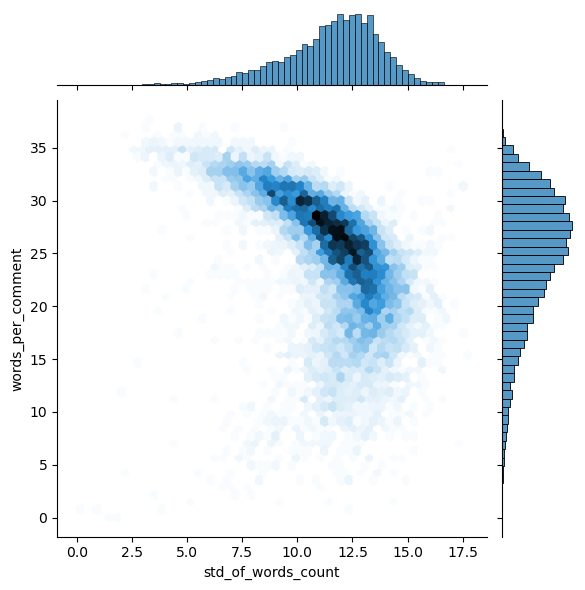

In [14]:
plt.figure(figsize=(12,6))

sns.jointplot(data=df, x='std_of_words_count', y='words_per_comment', kind='hex')
plt.show()

1. 當 'std_df_words_count' 較低時, 'words_per_comment'也較低, vice versa
2. 圖形中六邊形顏色越深代表有大量重疊

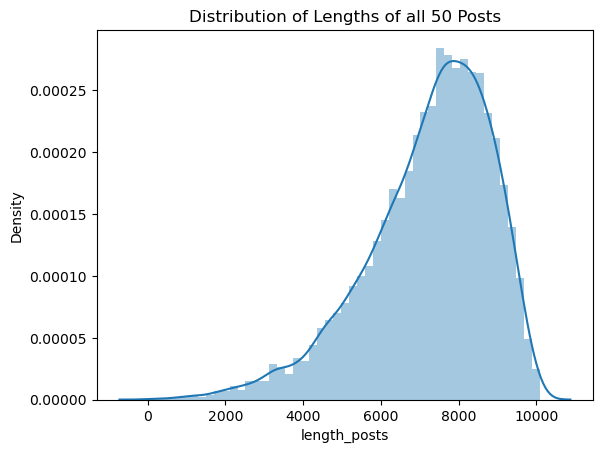

In [15]:
df['length_posts'] = df['posts'].apply(len)

sns.distplot(df['length_posts']).set_title('Distribution of Lengths of all 50 Posts')
plt.show()

* most of the posts have between 7000-9000 words

In [16]:
nested_words = list(df['posts'].apply(lambda x: x.split()))

# Find the most common words
def flatten_list(nested_list):
    flat_list = []
    for post in nested_list:
        for words in post:
            flat_list.append(words)
    return flat_list


flat_words = flatten_list(nested_words)

word_counts = Counter(flat_words)
most_common_words = word_counts.most_common(40)   

In [17]:
most_common_words

[('I', 387957),
 ('to', 290168),
 ('the', 270699),
 ('a', 230918),
 ('and', 219498),
 ('of', 177853),
 ('is', 128804),
 ('you', 128750),
 ('that', 127221),
 ('in', 117263),
 ('my', 104561),
 ('it', 93101),
 ('for', 83057),
 ('have', 79784),
 ('with', 77131),
 ('but', 74729),
 ('be', 69317),
 ('are', 65034),
 ('like', 61390),
 ('not', 59496),
 ('an', 59020),
 ("I'm", 57339),
 ('on', 57062),
 ('was', 56146),
 ('me', 55488),
 ('as', 53310),
 ('this', 52601),
 ('just', 48292),
 ('about', 46305),
 ('think', 46229),
 ('or', 45724),
 ("don't", 44821),
 ('so', 42935),
 ('your', 40918),
 ('do', 40867),
 ('what', 37746),
 ('at', 37566),
 ('can', 37535),
 ('if', 37042),
 ('people', 35546)]

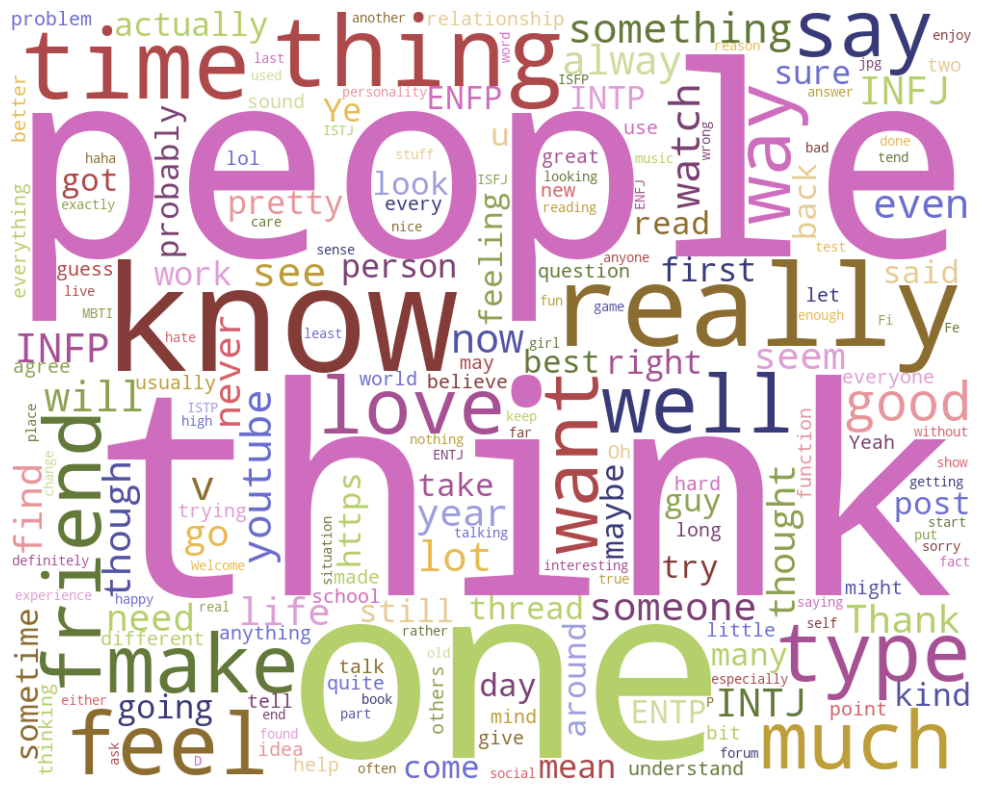

In [18]:
# Plotting the most common words
wc = wordcloud.WordCloud(width=1000, height=800, collocations=False, background_color='White',
                         colormap='tab20b').generate(" ".join(flat_words))
plt.figure(figsize=(15,10))
plt.imshow(wc, interpolation='bilinear')
_ = plt.axis("off")

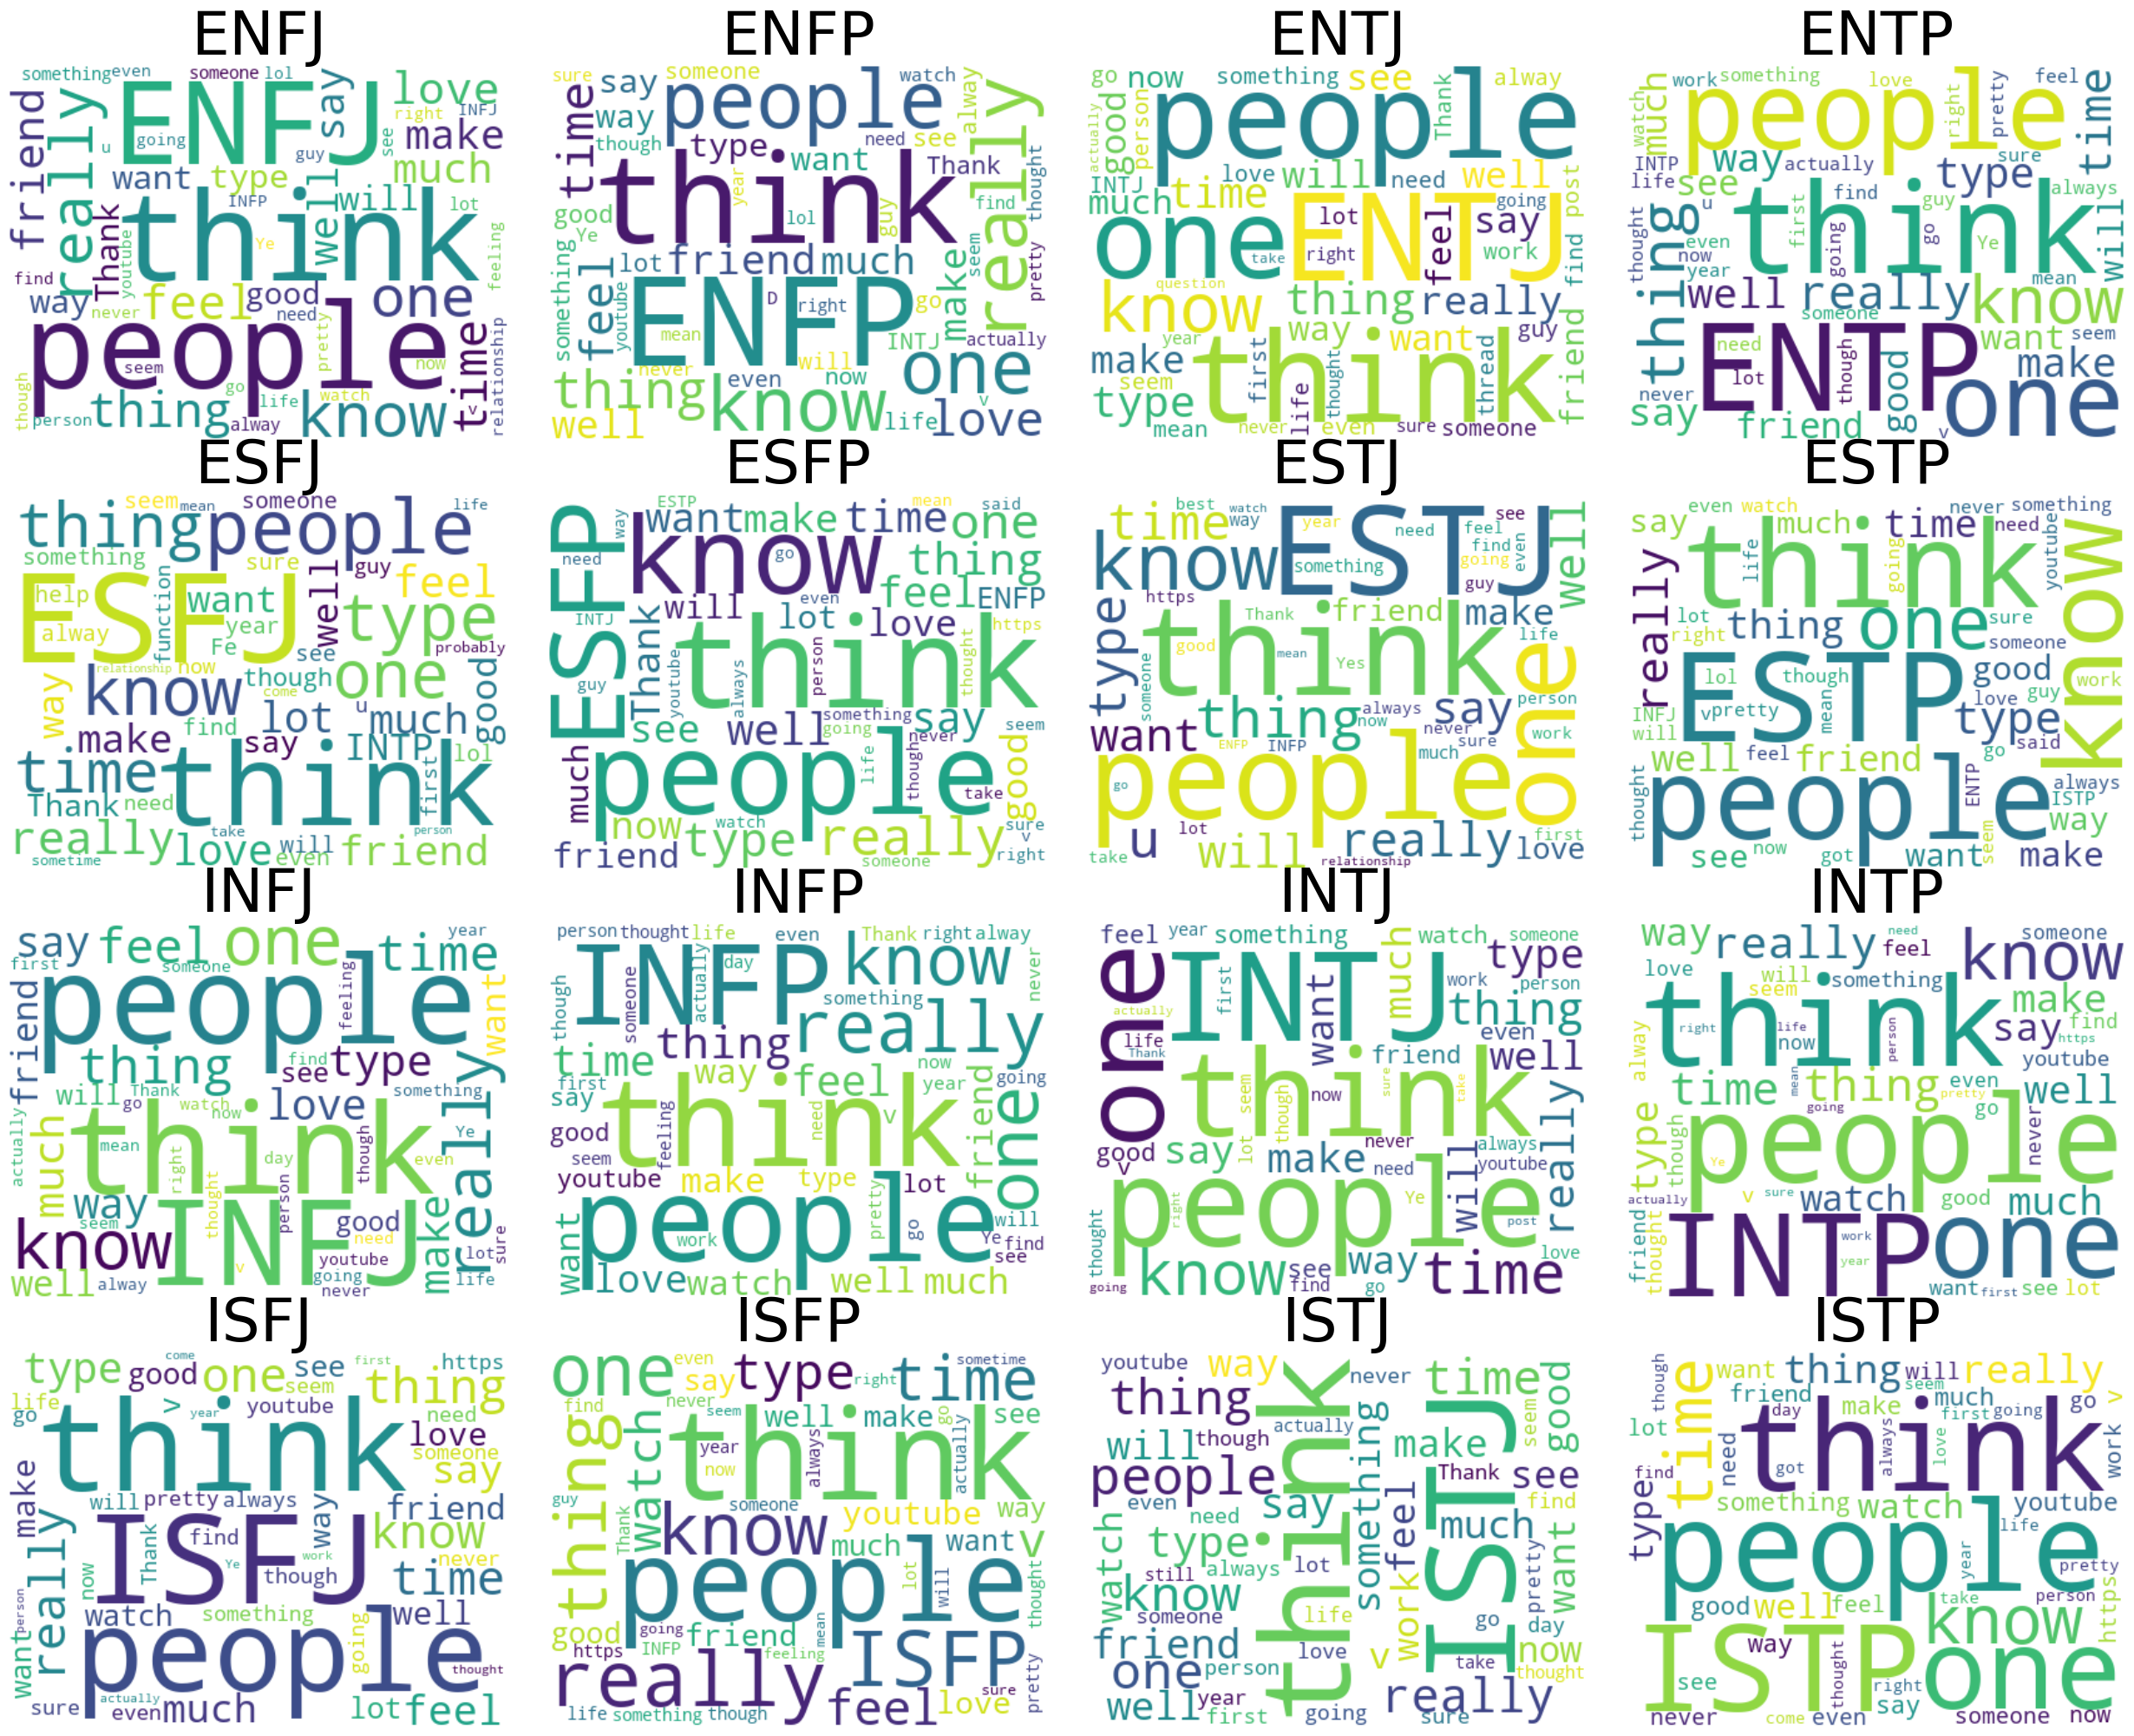

In [19]:
def generate_wordclouds(df):
    fig, axes = plt.subplots(4, 4, figsize=(25, 20))  
    axes = axes.flatten()  #用 flatten使二維變一維, 這樣就能用一個for loop就好,不用用到兩個去對應列與行

   # 因 enumerate返回(index這就是 i),另外 groupby返回(key,dataframe)
   # so, actual is index,(group_key, group_dataframe)
    for i, (mbti_type, subset) in enumerate(df.groupby('type')):
        text = ' '.join(subset['posts'])  # 合併本文
        wc = WordCloud(width=400, height=300, max_words=50, collocations=False, 
                       background_color="white", max_font_size=100).generate(text)
        
        axes[i].imshow(wc, interpolation='bilinear')
        axes[i].axis("off")
        axes[i].set_title(mbti_type, fontsize=50)  # 設置每個圖的標題為 MBTI type
         
    # 調整圖的間距
    plt.tight_layout(pad=1)
    plt.show()

generate_wordclouds(df)

In [20]:
# Count the users and posts
# posts[1] is the post, posts[0] is type of MBTI
def extract(posts, new_posts):
    for post in posts[1].split('|||'):
        new_posts.append((posts[0],post))
    
posts = []
df.apply(lambda x: extract(x, posts), axis=1)

print("Number of users", len(df))
print("Number of posts", len(posts))
print("5 posts from start are:")
posts[0:5]

Number of users 8675
Number of posts 422845
5 posts from start are:


[('INFJ', "'http://www.youtube.com/watch?v=qsXHcwe3krw"),
 ('INFJ', 'http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg'),
 ('INFJ',
  'enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks'),
 ('INFJ', 'What has been the most life-changing experience in your life?'),
 ('INFJ',
  'http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/watch?v=u8ejam5DP3E  On repeat for most of today.')]

## Preprocessing Data

In [21]:
def preprocess_text(df, remove_special=True):
    texts = df['posts'].copy()
    labels = df['type'].copy()

    #Remove links 
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'https?:\/\/.*?[\s+]', '', x.replace("|"," ") + " "))
    
    #Keep the End Of Sentence characters
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'\.', ' EOSTokenDot ', x + " "))
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'\?', ' EOSTokenQuest ', x + " "))
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'!', ' EOSTokenExs ', x + " "))
    
    #Strip Punctation
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'[\.+]', ".",x))

    #Remove multiple fullstops
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'[^\w\s]','',x))

    #Remove Non-words
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'[^a-zA-Z\s]','',x))

    #Convert posts to lowercase
    df["posts"] = df["posts"].apply(lambda x: x.lower())

    #Remove multiple letter repeating words
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'([a-z])\1{2,}[\s|\w]*','',x)) 

    #Remove very short or long words
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'(\b\w{0,3})?\b','',x)) 
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'(\b\w{30,1000})?\b','',x))

    # Remove MBTI Personality Words - crutial in order to get valid model accuracy estimation for unseen data. 
    # compile為編譯器 可使之後靈活運用, 編譯後儲存了正則化的形式,以後匹配其他句子時就不需要重新解析
    if remove_special:
        pers_types = ['INFP' ,'INFJ', 'INTP', 'INTJ', 'ENTP', 'ENFP', 'ISTP' ,'ISFP' ,'ENTJ', 'ISTJ','ENFJ',
                      'ISFJ' ,'ESTP', 'ESFP' ,'ESFJ' ,'ESTJ']
        pers_types = [p.lower() for p in pers_types]
        p = re.compile("(" + "|".join(pers_types) + ")")
    
    return df

#Preprocessing of entered Text
new_df = preprocess_text(data)

* 使用 re.sub(r'https?:\/\/.*?[\s+]', '', x.replace("|"," ") + " ") 移除帖子中的所有HTTP和HTTPS鏈接。這通常是因為連結對文本分析和模型訓練沒有幫助，可能會引入噪聲。

* 替換結束語句標記：將句點.、問號?和感嘆號!替換為特定的標記（EOSTokenDot, EOSTokenQuest, EOSTokenExs）。可以幫助模型更好地識別句子結尾。

* 簡化標點符號和非單詞字符,移除或簡化文本中的標點符號和非單詞字符，如連續的句點被替換為單個句點，然後移除所有非字母和非空格字符，以清潔數據，減少分析中的變量。

* 文本統一化：將所有文本轉換為小寫，這是文本處理中常見的規範化步驟，有助於後續處理時忽略大小寫的差異。

* 移除重覆字母和極端長度單詞：移除重覆字符過多的單詞和長度極短或極長的單詞，這些單字通常不重要。

* 移除與MBTI類型相關的單詞（如果 remove_special 參數為 True)這一步是清除數據中可能影響模型性能的MBTI類型詞匯，例如在分類任務中，如果訓練數據中包含標簽名，則可能導致模型學到這些標簽而非從上下文中推斷類型。

In [22]:
# remove posts that less than min words
min_words = 15
print("Before : Number of posts", len(new_df)) 

# 使用正則表達式來查找帖子 x 中所有的單詞。正則表達式 r'\w+' 匹配由字母或數字組成的連續字符序列，這通常對應於英文單詞和數字。
new_df["no. of. words"] = new_df["posts"].apply(lambda x: len(re.findall(r'\w+', x)))
new_df = new_df[new_df["no. of. words"] >= min_words]

print("After : Number of posts", len(new_df))

Before : Number of posts 8675
After : Number of posts 8466


計算每個帖子的單詞數量並移除單詞數量少於15的帖子來進一步過濾數據。這確保了每個帖子都有足夠的內容進行有效的分析和模型訓練。
這部分使用了正則表達式 r'\w+' 匹配帖子(x)中的單詞（字母和數字組成的序列），並計算其數量。接著，通過比較這個數量是否達到設定的最小單詞數（15個），來決定是否保留該帖子。

## Feature Engineering

In [23]:
new_df.head()

type                                              posts  no. of. words
0  INFJ      enfp  intj moments   sportscenter    plays...            430
1  ENTP   finding  lack    these posts very alarming eo...            803
2  INTP  good         course  which    know thats  bles...            253
3  INTJ  dear intp    enjoyed  conversation  other  eos...            777
4  ENTJ  youre fired eostokendot    thats another silly...            402

In [24]:
# converting MBTI type to numerical form
label_en = LabelEncoder()

new_df['type of encoding'] = label_en.fit_transform(new_df['type'])

target = new_df['type of encoding']

In [25]:
new_df.head(10)

type                                              posts  no. of. words  \
0  INFJ      enfp  intj moments   sportscenter    plays...            430   
1  ENTP   finding  lack    these posts very alarming eo...            803   
2  INTP  good         course  which    know thats  bles...            253   
3  INTJ  dear intp    enjoyed  conversation  other  eos...            777   
4  ENTJ  youre fired eostokendot    thats another silly...            402   
5  INTJ    eostokendot    science    perfect eostokendo...            245   
6  INFJ    cant draw    nails haha eostokendot  those w...            970   
7  INTJ   tend  build   collection  things   desktop th...            140   
8  INFJ    sure thats  good question eostokendot   dist...            522   
9  INTP      this position where  have  actually     pe...            130   

   type of encoding  
0                 8  
1                 3  
2                11  
3                10  
4                 2  
5                10  
6                 8  
7                10  
8                 8  
9                11

In [26]:
# print stopwords

print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [27]:
count_vec = CountVectorizer(stop_words='english')

train = count_vec.fit_transform(new_df['posts'])

In [28]:
train.shape

(8466, 98555)

## Model Training: 70% train, 30% test

In [29]:
X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.3, stratify=target, random_state=42)

print((X_train.shape), (y_train.shape), (X_test.shape), (y_test.shape))

(5926, 98555) (5926,) (2540, 98555) (2540,)


In [30]:
accuracies = {}

# Random Forest
rnf_c = RandomForestClassifier(n_estimators=100, random_state=42)
model_rnf = rnf_c.fit(X_train, y_train)

prediction = model_rnf.predict(X_test)

accuracy = accuracy_score(y_test, prediction)
accuracy_percent = round(accuracy*100,2)
accuracies['Random Forest'] = accuracy_percent

print(f'Random Forest Accuracy: {accuracy_percent}%')

Random Forest Accuracy: 37.68%


In [31]:
# XGBoost
xgb = XGBClassifier()
model_xgb = xgb.fit(X_train, y_train)

prediction = model_xgb.predict(X_test)

accuracy = accuracy_score(y_test, prediction)
accuracy_percent = round(accuracy*100,2)
accuracies['XGBoost'] = accuracy_percent

print(f'XGBoost Accuracy: {accuracy_percent}%')

XGBoost Accuracy: 57.56%


In [32]:
# SGD 
sgd = SGDClassifier(max_iter=6, tol=None)
model_sgd = sgd.fit(X_train, y_train)

prediction = model_sgd.predict(X_test)

accuracy = accuracy_score(y_test, prediction)
accuracy_percent = round(accuracy*100,2)
accuracies['Gradient Descent'] = accuracy_percent

print(f'Gradient Descent Accuracy: {accuracy_percent}%')

Gradient Descent Accuracy: 31.89%


In [33]:
# SVC
svc = SVC(random_state=42)
model_svc = svc.fit(X_train, y_train)

prediction = model_svc.predict(X_test)

accuracy = accuracy_score(y_test, prediction)
accuracy_percent = round(accuracy*100,2)
accuracies['SVC'] = accuracy_percent

print(f'SVC Accuracy: {accuracy_percent}%')

SVC Accuracy: 35.39%


In [34]:
ada = AdaBoostClassifier()
model_ada = ada.fit(X_train, y_train)

prediction = model_ada.predict(X_test)

accuracy = accuracy_score(y_test, prediction)
accuracy_percent = round(accuracy*100,2)
accuracies['AdaBoost'] = accuracy_percent

print(f'AdaBoost Accuracy: {accuracy_percent}%')

AdaBoost Accuracy: 29.61%


In [35]:
pd.DataFrame.from_dict(accuracies, orient='index', columns=['Accuracies(%)'])

Accuracies(%)
Random Forest             37.68
XGBoost                   57.56
Gradient Descent          31.89
SVC                       35.39
AdaBoost                  29.61

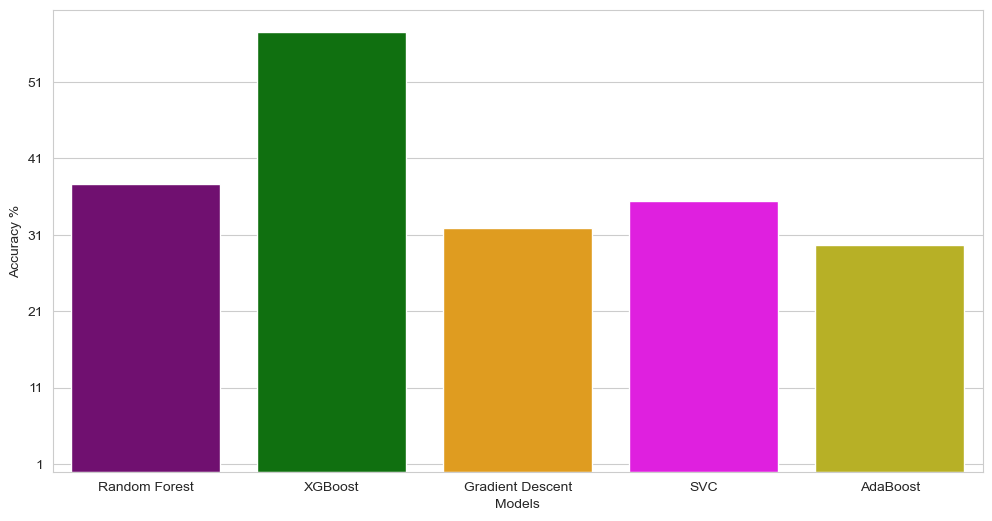

In [36]:
colors = ["purple", "green", "orange", "magenta","#CFC60E","#0FBBAE"]

sns.set_style('whitegrid')
plt.figure(figsize=(12,6))
plt.yticks(np.arange(1,100,10))
plt.ylabel("Accuracy %")
plt.xlabel("Models")
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()), palette=colors)
plt.show()

In [37]:
data2 = pd.read_csv('mbti_1.csv')
data2

type                                              posts
0     INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1     ENTP  'I'm finding the lack of me in these posts ver...
2     INTP  'Good one  _____   https://www.youtube.com/wat...
3     INTJ  'Dear INTP,   I enjoyed our conversation the o...
4     ENTJ  'You're fired.|||That's another silly misconce...
...    ...                                                ...
8670  ISFP  'https://www.youtube.com/watch?v=t8edHB_h908||...
8671  ENFP  'So...if this thread already exists someplace ...
8672  INTP  'So many questions when i do these things.  I ...
8673  INFP  'I am very conflicted right now when it comes ...
8674  INFP  'It has been too long since I have been on per...

[8675 rows x 2 columns]

In [38]:
# add column for personality type
def get_types(row):
    t=row['type']

    I = 0; N = 0
    T = 0; J = 0
    
    if t[0] == 'I': I = 1
    elif t[0] == 'E': I = 0
    else: print('I-E not found') 
        
    if t[1] == 'N': N = 1
    elif t[1] == 'S': N = 0
    else: print('N-S not found')
        
    if t[2] == 'T': T = 1
    elif t[2] == 'F': T = 0
    else: print('T-F not found')
        
    if t[3] == 'J': J = 1
    elif t[3] == 'P': J = 0
    else: print('J-P not found')
    return pd.Series( {'IE':I, 'NS':N , 'TF': T, 'JP': J }) 

data2 = data2.join(data.apply (lambda row: get_types(row),axis=1))
data2.head(5)

type                                              posts  IE  NS  TF  JP
0  INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...   1   1   0   1
1  ENTP  'I'm finding the lack of me in these posts ver...   0   1   1   0
2  INTP  'Good one  _____   https://www.youtube.com/wat...   1   1   1   0
3  INTJ  'Dear INTP,   I enjoyed our conversation the o...   1   1   1   1
4  ENTJ  'You're fired.|||That's another silly misconce...   0   1   1   1

In [39]:
# see each personality 
print ("Introversion (I) / Extroversion (E):\t", data2['IE'].value_counts()[1], " / ", data2['IE'].value_counts()[0])
print ("Intuition (N) / Sensing (S):\t\t", data2['NS'].value_counts()[1], " / ", data2['NS'].value_counts()[0])
print ("Thinking (T) / Feeling (F):\t\t", data2['TF'].value_counts()[1], " / ", data2['TF'].value_counts()[0])
print ("Judging (J) / Perceiving (P):\t\t", data2['JP'].value_counts()[1], " / ", data2['JP'].value_counts()[0])

Introversion (I) / Extroversion (E):	 6676  /  1999
Intuition (N) / Sensing (S):		 7478  /  1197
Thinking (T) / Feeling (F):		 3981  /  4694
Judging (J) / Perceiving (P):		 3434  /  5241


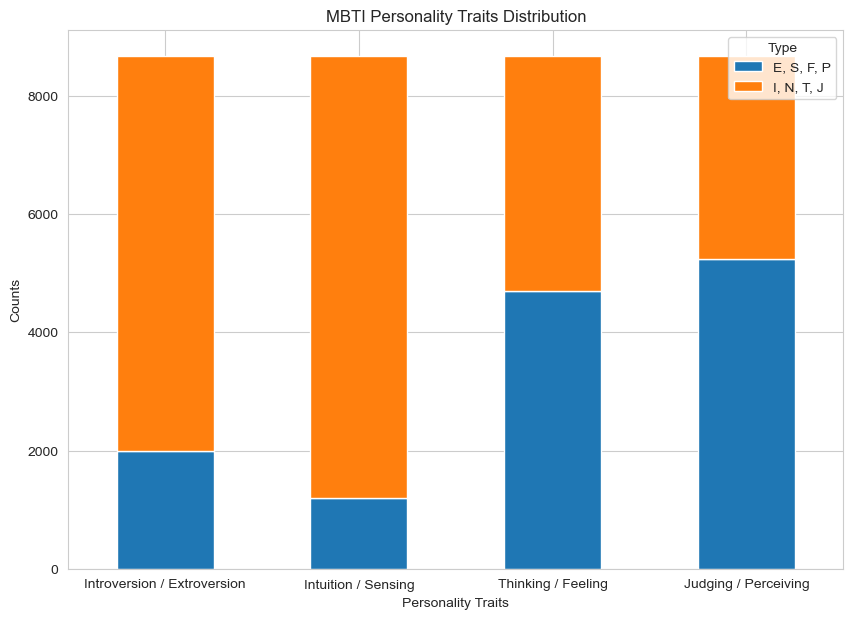

In [40]:
intro_extro_counts = data2['IE'].value_counts()
intuit_sense_counts = data2['NS'].value_counts()
think_feel_counts = data2['TF'].value_counts()
judge_perceive_counts = data2['JP'].value_counts()

plot_data = pd.DataFrame({'Introversion / Extroversion': intro_extro_counts,
                         'Intuition / Sensing': intuit_sense_counts,
                         'Thinking / Feeling': think_feel_counts,
                         'Judging / Perceiving': judge_perceive_counts}).transpose()

plot_data.columns =['E, S, F, P','I, N, T, J']

plot_data.plot(kind='bar', stacked=True, figsize=(10,7), color=['#1f77b4', '#ff7f0e'])
plt.title('MBTI Personality Traits Distribution')
plt.xlabel('Personality Traits')
plt.ylabel('Counts')
plt.xticks(rotation=0) 
plt.legend(title='Type')
plt.show()

In [41]:
data_cor = data2[['IE','NS','TF','JP']].corr()

data_cor

IE        NS        TF        JP
IE  1.000000 -0.045899 -0.069573  0.161939
NS -0.045899  1.000000 -0.080954  0.014922
TF -0.069573 -0.080954  1.000000 -0.004673
JP  0.161939  0.014922 -0.004673  1.000000

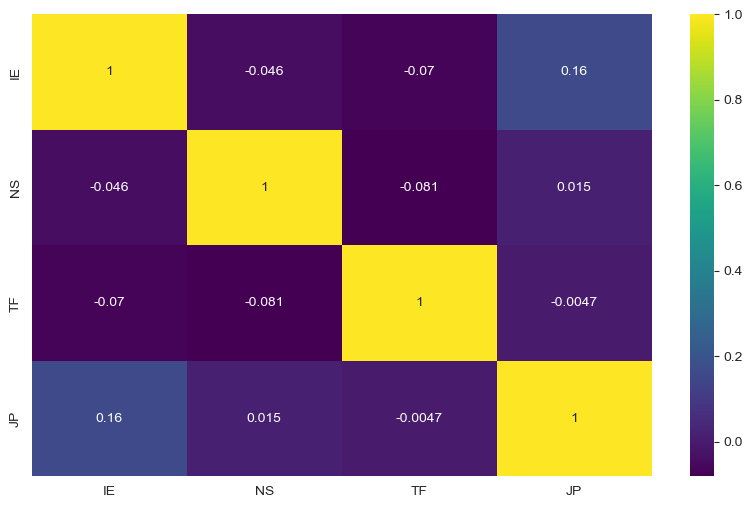

In [42]:
plt.figure(figsize=(10,6))
sns.heatmap(data_cor, cmap='viridis', annot=True)
plt.show()

### WordNetLemmatizer 的用途包括：

* 規範化文本：通過將單詞還原到基本形式，幫助統一文本數據，例如將動詞從不同的時態（如 "running", "ran"）還原到原形（如 "run"），或將名詞的覆數形式（如 "mice"）還原到單數形式（如 "mouse"）。這有助於減少處理詞匯的多樣性，使算法能夠更容易識別和處理文本。

* 提高文本處理的效果：在文本分類、情感分析或主題建模等，通過詞形還原預處理文本可以提高模型的性能，因為模型處理的單詞種類更少，數據的一致性更高。

* 與詞性標注結合使用：WordNetLemmatizer 通常與詞性標注（POS Tagging）結合使用，可以更準確地識別單詞在特定上下文中的正確詞形。例如，詞 "saw" 可以根據上下文是名詞 "a tool" 或是動詞 "see" 的過去式。

In [43]:
lemmatiser = WordNetLemmatizer()

useless_words = stopwords.words('english')

unique_type = ['INFJ', 'ENTP', 'INTP', 'INTJ', 'ENTJ', 'ENFJ', 'INFP', 'ENFP',
               'ISFP', 'ISTP', 'ISFJ', 'ISTJ', 'ESTP', 'ESFP', 'ESTJ', 'ESFJ']

unique_type = [x.lower() for x in unique_type]

In [44]:
binary_Pers = {'I':1, 'E':0, 'N':1, 'S':0, 'F':1, 'T':0, 'J':1, 'P':0}
binary_Pers_list = [{1:'I', 0:'E'}, {1:'N', 0:'S'}, {1:'F', 0:'T'}, {1:'J', 0:'P'}]

def translate_personality(personality):
    
    # transform to binary
    return [binary_Pers[l] for l in personality]

binary_list = np.array([translate_personality(p) for p in data2['type']])
print(f'Binary MBTI list: \n {binary_list}')

Binary MBTI list: 
 [[1 1 1 1]
 [0 1 0 0]
 [1 1 0 0]
 ...
 [1 1 0 0]
 [1 1 1 0]
 [1 1 1 0]]


In [45]:
# transform to MBTI type (output)
def translate_back(personality):
    s = ""
    for i, l in enumerate(personality):
        s += binary_Pers_list[i][l]
    return s

例如，如果personality是[1, 0, 1, 0]，處理過程如下：

* 對於i=0（處理I/E維度），l=1，查找{1: 'I', 0: 'E'}，找到'I'。
* 對於i=1（處理N/S維度），l=0，查找{1: 'N', 0: 'S'}，找到'S'。
* 對於i=2（處理T/F維度），l=1，查找{1: 'F', 0: 'T'}，找到'F'。
* 對於i=3（處理J/P維度），l=0，查找{1: 'J', 0: 'P'}，找到'P'。

In [46]:
# nltk.download('wordnet')

In [47]:
def preprocess_text(data, remove_stop_words=True, remove_mbti_profiles=True):
    
    list_personality = []
    list_posts = []
    len_data = len(data)
    i = 0   #用來追蹤處理到數據中的哪一行
    
    for row in data.iterrows():
        
        # Remove and clean comments
        # row[0]=index, row[1]=value
        posts = row[1]['posts']
        
        #remove url links
        temp = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ', posts)
        
        # 刪除字母以外的所有符號
        temp = re.sub("[^a-zA-Z]", " ", temp)
        
        # 移除多餘空格,將連續空格替換成單個空格,並將所有字母轉換成小寫
        temp = re.sub(' +', ' ', temp).lower()
        
        # 移除包含重複字母的單詞
        temp = re.sub(r'([a-z])\1{2,}[\s|\w]*', '', temp)
        
        # 如果 remove_stop_words 為 True，則只有不在 useless_words 中的單詞會被詞形還原處理
        # 如果 remove_stop_words 為 False，則所有的單詞都會被詞形還原處理。
        if remove_stop_words:
            temp = " ".join([lemmatiser.lemmatize(w) for w in temp.split(' ') if w not in useless_words])
        else:
            temp = " ".join([lemmatiser.lemmatize(w) for w in temp.split(' ')])
        
        # 移除 MBTI的字,為了不影響模型的公正度
        if remove_mbti_profiles:
            for t in unique_type:
                temp = temp.replace(t, " ")
             
        list_posts.append(temp)
        
    list_posts = np.array(list_posts)
        
    return list_posts

In [48]:
list_posts = preprocess_text(data2, remove_stop_words=True, remove_mbti_profiles=True)

print("Example :")
print("\nPost before preprocessing:\n\n", data2['posts'][0])
print("\nPost after preprocessing:\n\n", list_posts[0])

Example :

Post before preprocessing:

 'http://www.youtube.com/watch?v=qsXHcwe3krw|||http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg|||enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks|||What has been the most life-changing experience in your life?|||http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/watch?v=u8ejam5DP3E  On repeat for most of today.|||May the PerC Experience immerse you.|||The last thing my INFJ friend posted on his facebook before committing suicide the next day. Rest in peace~   http://vimeo.com/22842206|||Hello ENFJ7. Sorry to hear of your distress. It's only natural for a relationship to not be perfection all the time in every moment of existence. Try to figure the hard times as times of growth, as...|||84389  84390  http://wallpaperpassion.com/upload/23700/friendship-boy-and-girl-wallpaper.jpg  http://assets.dornob.com/wp-content/up

In [49]:
# using CountVectorizer turn the word into vector
count_vec = CountVectorizer(analyzer='word', #以單字進行分析
                            max_features=1000, #限制轉換後考慮的最大詞彙數量
                            max_df=0.7, # 忽略超過70% posts出現的詞彙(過於常見的詞彙)
                            min_df=0.1) # 忽略低於10% posts出現的詞彙(過於罕見的詞彙)

print('Using CountVectorizer')
X_count = count_vec.fit_transform(list_posts)

# enumerate is useful for obtaining an index list, can use to track and count value
features_name = list(enumerate(count_vec.get_feature_names_out()))
print('10 features names can be seen below')
print(features_name[0:10])

# tfidf 可以計算詞彙權重
tfidf = TfidfTransformer()
X_tfidf = tfidf.fit_transform(X_count).toarray()

print("\nUsing Tf-idf :")
print("Now the dataset size is as below")
print(X_tfidf.shape)

Using CountVectorizer
10 features names can be seen below
[(0, 'ability'), (1, 'able'), (2, 'absolutely'), (3, 'across'), (4, 'act'), (5, 'action'), (6, 'actually'), (7, 'add'), (8, 'advice'), (9, 'afraid')]

Using Tf-idf :
Now the dataset size is as below
(8675, 595)


TF-IDF 轉換的目的是提升文本數據中詞匯的權重。頻繁出現的詞（如常見助詞等）可能對文檔的區分度不高，因此它們的權重被降低；而特殊詞匯（不常見但具有強烈特定上下文意義的詞）權重則被提高，因為它們能更好代表和區分文檔內容。

In [50]:
personality_type = [ "IE: Introversion (I) / Extroversion (E)", "NS: Intuition (N) / Sensing (S)", 
                   "FT: Feeling (F) / Thinking (T)", "JP: Judging (J) / Perceiving (P)"  ]

for l in range(len(personality_type)):
    print(personality_type[l])

IE: Introversion (I) / Extroversion (E)
NS: Intuition (N) / Sensing (S)
FT: Feeling (F) / Thinking (T)
JP: Judging (J) / Perceiving (P)


In [51]:
# the posts look in tf-idf
print(f'X: 1st posts in tf-idf representation\n{X_tfidf[0]}')

X: 1st posts in tf-idf representation
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.08105478 0.07066064
 0.         0.         0.         0.         0.         0.
 0.         0.04516864 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.05321691 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.0871647  0.         0.         0.
 0.         0.         0.         0.05506308 0.0708757  0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.16585935 0.         0.         0.09676192 0.
 0.         0.04970682 0.         0.         0.         0.
 0.07397056 0.         0.         0.         0.         0.
 0.       

## Build and Evaluate the Models

In [52]:
list_personality = [translate_personality(row) for row in df['type']]
list_personality = np.array(list_personality)

In [53]:
X = X_tfidf

for l in range(len(personality_type)):
    y = list_personality[:,l]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [54]:
# Random Forest 
for l in range(len(personality_type)):
    
    y = list_personality[:,l]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    model = RandomForestClassifier()
    model.fit(X_train, y_train)

    rfc_prediction = model.predict(X_test)
    
    # evaluate predictions
    accuracy = accuracy_score(y_test, rfc_prediction)
    
    print("%s Accuracy: %.2f%%" % (personality_type[l], accuracy * 100.0))

IE: Introversion (I) / Extroversion (E) Accuracy: 77.68%
NS: Intuition (N) / Sensing (S) Accuracy: 85.52%
FT: Feeling (F) / Thinking (T) Accuracy: 69.23%
JP: Judging (J) / Perceiving (P) Accuracy: 60.97%


In [55]:
# XGBoost
for l in range(len(personality_type)):
    
    y = list_personality[:,l]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    model = XGBClassifier()
    model.fit(X_train, y_train)

    xgb_prediction = model.predict(X_test)
    accuracy = accuracy_score(y_test, xgb_prediction)
    
    print("%s Accuracy: %.2f%%" % (personality_type[l], accuracy * 100.0))

IE: Introversion (I) / Extroversion (E) Accuracy: 76.57%
NS: Intuition (N) / Sensing (S) Accuracy: 85.21%
FT: Feeling (F) / Thinking (T) Accuracy: 69.42%
JP: Judging (J) / Perceiving (P) Accuracy: 61.62%


In [56]:
# Gradient Descent
for l in range(len(personality_type)):
    
    y = list_personality[:,l]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    model = SGDClassifier()
    model.fit(X_train, y_train)

    sgd_prediction = model.predict(X_test)
    accuracy = accuracy_score(y_test, sgd_prediction)
    
    print("%s Accuracy: %.2f%%" % (personality_type[l], accuracy * 100.0))

IE: Introversion (I) / Extroversion (E) Accuracy: 77.91%
NS: Intuition (N) / Sensing (S) Accuracy: 85.52%
FT: Feeling (F) / Thinking (T) Accuracy: 71.80%
JP: Judging (J) / Perceiving (P) Accuracy: 63.58%


In [57]:
# SVC
for l in range(len(personality_type)):
    
    y = list_personality[:,l]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    model = SVC()
    model.fit(X_train, y_train)

    svc_prediction = model.predict(X_test)
    accuracy = accuracy_score(y_test, svc_prediction)
    
    print("%s Accuracy: %.2f%%" % (personality_type[l], accuracy * 100.0))

IE: Introversion (I) / Extroversion (E) Accuracy: 77.95%
NS: Intuition (N) / Sensing (S) Accuracy: 85.52%
FT: Feeling (F) / Thinking (T) Accuracy: 72.65%
JP: Judging (J) / Perceiving (P) Accuracy: 64.31%


In [58]:
# AdaBoost
for l in range(len(personality_type)):
    
    y = list_personality[:,l]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    model = AdaBoostClassifier()
    model.fit(X_train, y_train)

    ada_prediction = model.predict(X_test)
    accuracy = accuracy_score(y_test, ada_prediction)
    
    print("%s Accuracy: %.2f%%" % (personality_type[l], accuracy * 100.0))

IE: Introversion (I) / Extroversion (E) Accuracy: 76.68%
NS: Intuition (N) / Sensing (S) Accuracy: 84.56%
FT: Feeling (F) / Thinking (T) Accuracy: 68.23%
JP: Judging (J) / Perceiving (P) Accuracy: 62.70%


In [59]:
# Logistic Regression
for l in range(len(personality_type)):
    
    y = list_personality[:,l]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    model = LogisticRegression()
    model.fit(X_train, y_train)

    log_prediction = model.predict(X_test)
    accuracy = accuracy_score(y_test, log_prediction)
    
    print("%s Accuracy: %.2f%%" % (personality_type[l], accuracy * 100.0))

IE: Introversion (I) / Extroversion (E) Accuracy: 77.22%
NS: Intuition (N) / Sensing (S) Accuracy: 85.59%
FT: Feeling (F) / Thinking (T) Accuracy: 72.45%
JP: Judging (J) / Perceiving (P) Accuracy: 63.62%


## Prediction

In [60]:
# Use Bayesian Optimization seatching parameters
# def objection(n_estimators, learning_rate, max_depth, subsample, colsample_bytree, gamma):
    
 #   n_estimators = int(n_estimators)
 #   max_depth = int(max_depth)
 #   gamma = int(gamma)
    
 #   model = XGBClassifier(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth,
  #                        subsample=subsample, colsample_bytree=colsample_bytree, gamma=gamma,
   #                       use_label_encoder=False, eval_metric='logloss', random_state=42)
    
  #  xgb_pipeline = Pipeline([('model', model)])
    
  #  score = cross_val_score(xgb_pipeline, X_train, y_train, cv=5, scoring='accuracy')
    
  #  return np.mean(score)

# pbounds = {'n_estimators':(100,1000), 'learning_rate':(0.01,0.3), 'max_depth':(3,10),
  #         'subsample':(0.5,1.0), 'colsample_bytree':(0.5,1.0),'gamma':(0,5)}

# optimizer = BayesianOptimization(f=objection, pbounds=pbounds, random_state=42)

# optimizer.maximize(init_points=20, n_iter=40)

# print(optimizer.max)

# output
#    'n_estimators': 679,  # 参数需要为整数
#    'learning_rate': 0.02886496196573106,
#    'max_depth': 10,  # 参数需要为整数
#    'subsample': 0.9041986740582306,
#    'colsample_bytree': 0.8037724259507192,
#    'gamma': 0.8526206184364576

In [62]:
# It seems to be a 
my_posts  = """Wow, what a weekend! Just got back from a community sports event and I'm still buzzing from the 
excitement. It's incredible how much energy you can draw from being around others who share the same passion 
for sports. We played soccer, volleyball, and even tried a bit of ultimate frisbee. After the games, we all went
for a big group dinner, which turned into an impromptu karaoke session. I love meeting new people and making 
connections—it's like each person brings a unique story to the table. Can't wait for the next meetup, hoping to 
see some familiar faces and meet even more new friends!!"""

mydata = pd.DataFrame(data={'posts': [my_posts]})

my_posts_processed = preprocess_text(mydata, remove_stop_words=True, remove_mbti_profiles=True)

my_X_cnt = count_vec.transform(my_posts_processed)

my_X_tfidf = tfidf.transform(my_X_cnt).toarray()

In [63]:
params = {
    'n_estimators': 600,
    'max_depth': 10,
    'gamma': 0.85,
    'learning_rate': 0.3,
    'subsample': 0.9,
    'colsample_bytree': 0.8}

result = []
for i in range(len(personality_type)):
    print(f"{personality_type[i]} classifier trained")
   
    # 從list_personality數據集中獲取當前維度的標籤
    y = list_personality[:, i]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

    model = XGBClassifier(**params)
    model.fit(X_train_smote, y_train_smote)
    
    # 預測並存儲結果
    xgb_prediction = model.predict(my_X_tfidf)
    result.append(xgb_prediction[0])

IE: Introversion (I) / Extroversion (E) classifier trained
NS: Intuition (N) / Sensing (S) classifier trained
FT: Feeling (F) / Thinking (T) classifier trained
JP: Judging (J) / Perceiving (P) classifier trained


In [64]:
print("MBTI result is: ", translate_back(result))

MBTI result is:  ENFJ


* 外向（Extraverted）: ENFJ 通常熱愛社交和與人互動。文章中描述的人物從參加社區體育活動和與他人共進晚餐的激情和能量中得到了巨大的滿足，這顯示了一種典型的外向行為模式。

* 直覺（Intuitive）: 直覺型的人喜歡思考可能性，傾向於注重未來和大局。文章中的叙述者對未來的活動抱有期待，並且從周圍人的故事中汲取靈感，這表現了對深層次連接和未來可能性的興趣。

* 情感(Feeling）: ENFJ 重視人際關係和他人的感受。文章中提到的“我喜歡與新人相遇和建立聯繫”，以及對每個人帶來獨特故事的欣賞，體現了 ENFJ 的情感導向和人際敏感性。

* 計劃（Judging）: 傾向於組織和計劃，ENFJ 人格希望能夠安排和組織活動以促進社交互動。文章中的活動似乎都有計劃和組織，如安排多種運動和群體晚餐，這符合 ENFJ 的領導和組織天賦。

以上所述 符合ENFJ是合理的。

In [66]:
my_posts  = """This weekend, I found myself lost in the world of books once again. There’s a quiet comfort in 
turning the pages, each story offering a temporary escape from the routine. I spent hours in my favorite chair,
a cup of tea by my side, and let the words transport me to different realms. Later, I took a long walk alone in
the nearby park. The solitude was refreshing, and it gave me time to ponder the lessons and emotions the stories
stirred within me. It was a peaceful day, exactly what I needed to recharge before facing another busy week.
Sometimes, it's these moments of quiet and reflection that provide the most profound joy."""

mydata = pd.DataFrame(data={'posts': [my_posts]})

my_posts_processed = preprocess_text(mydata, remove_stop_words=True, remove_mbti_profiles=True)

my_X_cnt = count_vec.transform(my_posts_processed)

my_X_tfidf = tfidf.transform(my_X_cnt).toarray()

In [67]:
params = {
    'n_estimators': 600,
    'max_depth': 10,
    'gamma': 0.85,
    'learning_rate': 0.3,
    'subsample': 0.9,
    'colsample_bytree': 0.8}

result = []
for i in range(len(personality_type)):
    print(f"{personality_type[i]} classifier trained")
   
    # 從list_personality數據集中獲取當前維度的標籤
    y = list_personality[:, i]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

    model = XGBClassifier(**params)
    model.fit(X_train_smote, y_train_smote)
    
    # 預測並存儲結果
    xgb_prediction = model.predict(my_X_tfidf)
    result.append(xgb_prediction[0])

IE: Introversion (I) / Extroversion (E) classifier trained
NS: Intuition (N) / Sensing (S) classifier trained
FT: Feeling (F) / Thinking (T) classifier trained
JP: Judging (J) / Perceiving (P) classifier trained


In [68]:
print("MBTI result is: ", translate_back(result))

MBTI result is:  INFJ


* 內向（Introverted）: 文章中描述了獨自在家中讀書和在公園中獨行的情景。這種享受獨處的時間和空間來反思和充電的行為典型地反映了內向性格的特徵。

* 直覺（Intuitive）: 描述中對不同領域的遐想和通過故事來逃離日常生活的描繪顯示出對可能性的探索和對大局的關注，這是直覺型人格的一個顯著特徵。

* 情感（Feeling）: 文章中提到了對故事中情感和教訓的深入思考，這表明作者重視個人感受和價值判斷，這與情感導向的行為一致。

* 判斷（Judging）: 文章中的行為顯示出計劃性和組織性，比如選擇靜坐和散步來充電，這些活動有助於恢復秩序和準備新的一週，符合判斷型的特點。

以上所述 符合INFJ是合理的。

In [69]:
my_posts  = """Today was all about getting back to nature. I hit the hiking trails early in the morning to beat 
the crowd. The path was rough, with lots of rocks and roots, which made it a fun challenge to navigate. I focused
on the varied textures under my boots—mud, gravel, and leaves. The sounds of the forest were just as engaging; the
rustling leaves, distant bird calls, and even the silence was palpable. Stopped a few times just to take in the 
view and snap some photos of the wildlife. It’s these moments of deep connection with the environment that I 
really treasure."""

mydata = pd.DataFrame(data={'posts': [my_posts]})

my_posts_processed = preprocess_text(mydata, remove_stop_words=True, remove_mbti_profiles=True)

my_X_cnt = count_vec.transform(my_posts_processed)

my_X_tfidf = tfidf.transform(my_X_cnt).toarray()

In [70]:
params = {
    'n_estimators': 600,
    'max_depth': 10,
    'gamma': 0.85,
    'learning_rate': 0.3,
    'subsample': 0.9,
    'colsample_bytree': 0.8}

result = []
for i in range(len(personality_type)):
    print(f"{personality_type[i]} classifier trained")
   
    # 從list_personality數據集中獲取當前維度的標籤
    y = list_personality[:, i]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

    model = XGBClassifier(**params)
    model.fit(X_train_smote, y_train_smote)
    
    # 預測並存儲結果
    xgb_prediction = model.predict(my_X_tfidf)
    result.append(xgb_prediction[0])

IE: Introversion (I) / Extroversion (E) classifier trained
NS: Intuition (N) / Sensing (S) classifier trained
FT: Feeling (F) / Thinking (T) classifier trained
JP: Judging (J) / Perceiving (P) classifier trained


In [71]:
print("MBTI result is: ", translate_back(result))

MBTI result is:  INFP


* 內向（Introverted）: 描述了一個人早晨獨自去徒步旅行的經歷，這是典型的內向行為，顯示出享受獨處和個人空間的需要。

* 直覺（Intuitive）: 對自然環境深度的感知和描述，比如聆聽森林的聲音和觀察路徑的細節，展示了一種對未知的探索和對細節深入直覺的傾向。

* 情感（Feeling）: 對與環境的深刻連接和珍視這些時刻的表達反映了高度的情感參與和個人價值的體現。

* 感知（Perceiving）: 文章的敘述方式和活動的自發性（如隨時停下來拍照）表現出靈活和開放的態度，這是感知型人格的特點。

以上所述 符合INFP是合理的。